In [2]:
#If running in local mode, local to True. Otherwise, set it to false
local = True
model = "coronavirus_symptoms"

# Getting the Sagemaker role

In [3]:
import sagemaker
from sagemaker import get_execution_role

# S3 prefix
prefix = 'comment_classifier'

if local == True:
    sagemaker_session = sagemaker.LocalSession()
    role = 'arn:aws:iam::445861113736:role/service-role/AmazonSageMaker-ExecutionRole-20190903T114521'
else:
    sagemaker_session = sagemaker.Session()
    role = get_execution_role()

# Create SageMaker Scikit Estimator 

In [5]:
from sagemaker.sklearn.estimator import SKLearn

script_path = 'comment_classifier.py'
sklearn = SKLearn(
    entry_point=script_path,
    train_instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session,
    hyperparameters={'model': model,
                    'strip_accents': 'ascii',
                    'token_pattern': u'(?ui)\\b\\w*[a-z]+\\w*\\b', 
                    'lowercase': True, 
                    'stop_words': 'english', 
                    'min_df': 5,
                    'ngram_min': 1,
                    'ngram_max': 2})

# Training the Naive Bayes model

In [17]:
#The data should already be saved to the ./data directory
WORK_DIRECTORY = 'training_data'
train_input = sagemaker_session.upload_data(WORK_DIRECTORY, key_prefix="{}/{}".format(prefix, WORK_DIRECTORY) )

#Training the model
sklearn.fit({'train': train_input})

Creating tmpm3u9vli1_algo-1-2bix9_1 ... 
Attaching to tmpm3u9vli1_algo-1-2bix9_12mdone
algo-1-2bix9_1  | 2020-05-14 05:28:51,458 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
algo-1-2bix9_1  | 2020-05-14 05:28:51,464 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-2bix9_1  | 2020-05-14 05:28:51,480 sagemaker_sklearn_container.training INFO     Invoking user training script.
algo-1-2bix9_1  | 2020-05-14 05:28:51,846 sagemaker-containers INFO     Module comment_classifier does not provide a setup.py. 
algo-1-2bix9_1  | Generating setup.py
algo-1-2bix9_1  | 2020-05-14 05:28:51,847 sagemaker-containers INFO     Generating setup.cfg
algo-1-2bix9_1  | 2020-05-14 05:28:51,847 sagemaker-containers INFO     Generating MANIFEST.in
algo-1-2bix9_1  | 2020-05-14 05:28:51,847 sagemaker-containers INFO     Installing module with the following command:
algo-1-2bix9_1  | /miniconda3/bin/python -m pip install . 
algo-1-2bix9_1  

algo-1-2bix9_1  | /miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
algo-1-2bix9_1  |   import imp
algo-1-2bix9_1  | 2020-05-14 05:29:00,984 sagemaker-containers INFO     Reporting training SUCCESS
tmpm3u9vli1_algo-1-2bix9_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


# Using the trained model to make requests

## Creating the endpoint 

In [18]:
predictor = sklearn.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

Attaching to tmpn0hitsu2_algo-1-rvrl8_1
algo-1-rvrl8_1  | Processing /opt/ml/code
algo-1-rvrl8_1  | Building wheels for collected packages: comment-classifier
algo-1-rvrl8_1  |   Building wheel for comment-classifier (setup.py) ... done
algo-1-rvrl8_1  |   Created wheel for comment-classifier: filename=comment_classifier-1.0.0-py2.py3-none-any.whl size=6749 sha256=c931a94f5149adec5ba20c34bec209b7599c0f3b3d9fa89cb432243a3afa6ac8
algo-1-rvrl8_1  |   Stored in directory: /tmp/pip-ephem-wheel-cache-y874czqn/wheels/35/24/16/37574d11bf9bde50616c67372a334f94fa8356bc7164af8ca3
algo-1-rvrl8_1  | Successfully built comment-classifier
algo-1-rvrl8_1  | Installing collected packages: comment-classifier
algo-1-rvrl8_1  | Successfully installed comment-classifier-1.0.0
algo-1-rvrl8_1  | /miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for al

## Loading in testing data

In [49]:
import json
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

test_dir='./test_data/'
data_loc = '{0}{1}.json'.format(test_dir, model)
with open(data_loc, 'r') as infile:
    data = json.load(infile)
test_df = pd.io.json.json_normalize(data['data'])
y_test = test_df['target']

## Making predictions on new data
The endpoint takes in an array of comments and outputs an array of probabilities

In [ ]:
y_score = predictor.predict(test_df['description.comments'])

## ROC curve
The greater the area under the curve, the better (max 1.0)

algo-1-rvrl8_1  | 172.18.0.1 - - [14/May/2020:05:37:23 +0000] "POST /invocations HTTP/1.1" 200 58200 "-" "-"
The area under the curve is 0.92.


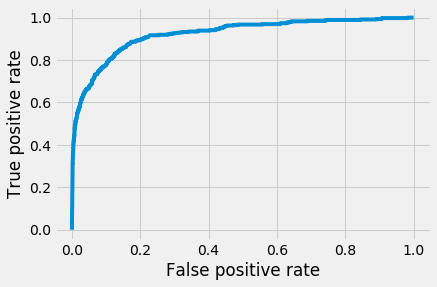

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr,tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
auc_score = roc_auc_score(y_test, y_score)
print('The area under the curve is {:0.2f}.'.format(auc_score))

## Probability histogram
How confident is the model generally?

(array([5110.,  135.,  134.,   75.,   80.,   73.,   90.,   77.,  132.,
        1353.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

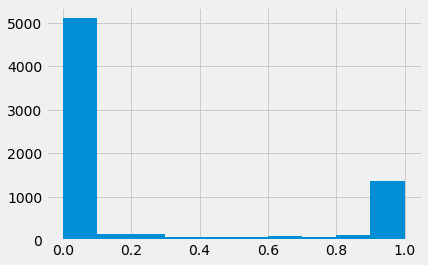

In [95]:
bins=np.linspace(0,1,11,endpoint=True)
plt.hist(y_score, bins=bins)

## Calibration plot
Shows how meaningful the probability outputs are. They're not well calibrated, but that's okay

Text(0, 0.5, 'Fraction True in bin')

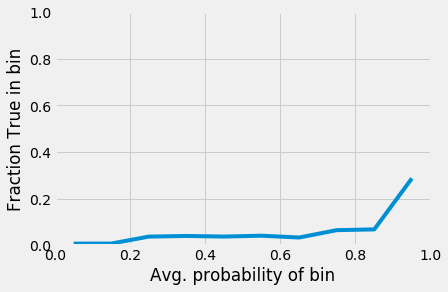

In [118]:
bins=np.linspace(0,1,11,endpoint=True)
bin_means = np.array(pd.Series(bins).rolling(window=2).mean().dropna())
bin_fractions = np.zeros(len(bin_means))

y_bins = pd.cut(y_score, bins=bins, labels=False)
for i in range(len(bin_means)):
    bin_fractions[i] = np.sum(y_test[y_bins==i])/np.sum(y_bins==i)

plt.plot(bin_means, bin_fractions)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Avg. probability of bin')
plt.ylabel('Fraction True in bin')

## Endpoint cleanup
Delete the endpoint when you're done so we don't pay extra

In [140]:
sklearn.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)
